# Discovering optimal topical sequences from science textbooks.

## Introduction
A complex body of knowledge is composed of numerous concepts and ideas that overlap and interconnect with one another.  For example, in sciences, the concept of energy may be used to explain the motion of an object in physics, the release of heat during a chemical reaction, and the metabolism of an organism in biology.  Hence, as a learning agent seeks to acquire knowledge and expertise, it would be prudent to strategize on how to navigate through a large body of information sources.  

A sequence of chapters and sections of a science textbook represents an example of a carefully designed path through topics.  While such a referential standard sequence by subject experts is highly valuable, there can be other topical trajectories that may be worthwhile to consider.  A learner may be considering a specific entry point to a subject or a target topic.  Also, different learning sequences could highlight different insights and connections between concepts and disciplines.  

Here, we present an algorithm for producing potential learning sequences through a corpus of science textbooks.  It may be useful for students or teachers for introductory collegiate science courses, where numerous, wide-ranging topics have to be introduced to a large group of students whose interests and learning goals also vary widely.  A biology student who knows about the membrane potential of a cell in a biology course can benefit from reading about the concept of electrical potential difference from a physics textbook.  Conversely, a physics student can reinforce the concept of electricity by learning about electrical phenomena in a cell from a biology textbook.  A teacher may use it to explore connections between different topics in a lesson plan.  





In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

Term frequency and inverse document frequency (tf-idf) values are calculated on the corpus of PHYS, CHEM, and BIOL texts from OpenStax.  The tf-idf value indicate how revelant or informative a term is.  This value is higher if a particular term is used often within a document, but it is also compensated by the term's frequency across the whole corpus.  Therefore, very common terms, such as articles and prepositions, will carry a very low value.  

The tf-idf calculation was done elsewhere, and in the code below, we load  the following data arrays: M_OS (tf-idf values; 2d matrix with dimension NxT), T_OS (terms; 1d array of length T), and OS_titles (section titles; 1d array of length N).

In [2]:
# Load data.
# Either: upload OS_all_M_T_title.p file or mount a Google Drive.

# If you mounted a google drive, you can specify the path.
#pathname = '/content/drive/My Drive/2020Summer_Research/Gabriel/'
#import os
#from google.colab import drive
#drive.mount('/content/drive')
#os.getcwd()
#os.chdir(pathname)

# If you uploaded the data file into Colab.
pathname = './'
if 1:
    with open(pathname+'OS_all_M_T_title.p','rb') as f:
        data = pickle.load(f)
    M_OS = data[0]
    T_OS = data[1]
    OS_titles = data[2]
    corpus_category = data[3]
    assert len(corpus_category)==len(OS_titles)
    print("\nPrinting the first few titles")
    print("\n".join(OS_titles[:10]))
    

M = M_OS
category_label = corpus_category
corpus_type = ['PHYS','CHEM','BIOL']
for i in range(len(OS_titles)):
    OS_titles[i] = corpus_type[int(corpus_category[i])] + ' ' + OS_titles[i]

# Reading the datafile from a csv file.
#import csv
#reader = csv.reader(open("data_section_tfidf.csv", "rt"), delimiter=",")
#x = list(reader)
#tfidf_matrix = np.array(x).astype("float")


Printing the first few titles
﻿1.0 Introduction to Science and the Realm of Physics, Physical Quantities, and Units
﻿1.1 Physics: An Introduction
﻿1.2 Physical Quantities and Units
﻿1.3 Accuracy, Precision, and Significant Figures
﻿1.4 Approximation
﻿2.0 Introduction to One-Dimensional Kinematics
﻿2.1 Displacement
﻿2.2 Vectors, Scalars, and Coordinate Systems
﻿2.3 Time, Velocity, and Speed
﻿2.4 Acceleration


## Methods

### Heuristics 
Once each document (i.e., each section), or node, has been vectorized with tf-idf values, the similarity or the pairwise distance, or edge, between any two documents can be calculated with a Euclidean metric.  The total distance spanning multipe nodes is the sum of pairwise distances.  The situation is akin to the Traveling Salesman Problem (TSP), where the objective is to minimize the traveling distance while visiting multiple cities. 

Since there are many nodes (~600), it is computational prohibitive to search for a global optimum (600 factorial possible paths).  Furthermore, the goal in this research is to explore interesting paths, rather than a single best path.  

A simple heuristic is to hop from the current node to the next nearest (most similar) node, as long as it has not been visited before. That way, a learning agent can go from one related document to another, so that there is a smooth learning trajectory without (ideally) having to make large conceptual leaps.  

However, this heuristic alone will always produce a single, deterministic path.  Therefore, the next nearest node is accepted with probability $p$.  If $p = 1$, there is rigidity in charting the path, but with $p < 1$, this heuristic algorithm explores less-optimal path in the short run, but may discover better global path, similar to simulated annealing algorithm.  This is similar to the situation where taking a small detour to get to a faster road can reduce the total amount of travel time.


In [3]:
def find_pdist (M):
    # M is number of points (row) x dimensions (column)
    pdist = np.sqrt(np.sum((M[None, :] - M[:, None])**2, -1))
    return pdist

def find_good_path (M, starting_point, prob=1.0, pathlen=0):
    # input: M is number of points (row) x dimensions (column)
    # output: good_path = list of length N
    # prob = Probability for accepting and rejecting the next point.
    #        (trying to avoid local min, c.f., simulated annealing).
    # prob = 1.0 (always accept the next closest point)
    # pathlen = number of nodes to travel.
    #         = 0 or N (the path through all nodes)

    # pdist = N x N 
    pdist = find_pdist(M)

    # good_path will be appended as we hop to the next nearest point.
    good_path = list()
    good_path.append(starting_point)

    N, _ = pdist.shape

    # Figure out how long path should be, based on the pathlen parameter.
    if pathlen>0: # pathlen was specified, so use that.
        if pathlen>N: # but there is a limit of N.
            pathlen = N
    else: # pathlen was not specified, so get the full path.
        pathlen = N

    for i in range(pathlen-1):
        curr_pt = good_path[i]

        dist_from_curr_pt = pdist[curr_pt,:]
        # index of points in ascending order of distances.
        idx = np.argsort(dist_from_curr_pt).tolist() # ordered index values.
        for j in good_path:
            idx.remove(j) # remove index that was already visited.

        # now index should only contain points that were unvisited, in 
        # an ascending order of distances from the current point.

        # Now, roll dice, and probabilistically accept points.
        p = np.random.rand(len(idx)) < prob
        if any(p):
            #print(np.argwhere(p==True)[0])
            # Find the first index of True value.
            j = idx[np.argwhere(p==True)[0][0]]
        else: # if no points were selected, choose a random point.
            j = idx[np.random.randint(len(idx))]

        good_path.append(j)

    # If we visited all nodes, the sorted path should be equal to range(N).
    #if pathlen==N:
    #    assert all(np.sort(good_path)==range(N))

    return good_path

def calculate_path_dist (pdist, path):
    # Find the total spanning path distance.
    path_dist = 0
    for i in range(len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        path_dist = path_dist + pdist[p1,p2]
    return path_dist
    
# Simple test cases.
testM = np.array([[0.1,0.5],[2,2.5],[3.1,2.9]])
assert all(find_good_path(testM,0)==np.array([0,1,2]))
assert all(find_good_path(testM,2)==np.array([2,1,0]))
assert all(find_good_path(testM,1)==np.array([1,2,0]))

In [4]:
# Sanity check
# Find sections with unusually small distances,
# which may indicate bad data (e.g., identical text files).

dist_thresh = 0.01
pdist = find_pdist(M) 
identical_sections = []
for i in range(len(pdist[0])):
    for j in range(len(pdist[0])):
        if pdist[i][j] < dist_thresh and i !=j :
            print('%4d <---> %4d with Distance = %3.2f'%(i,j,pdist[i][j]))
            print('\t%s'%OS_titles[i])
            print('\t%s'%OS_titles[j])
            identical_sections.append("%4d - %4d" % (i,j))
#print(identical_sections) 

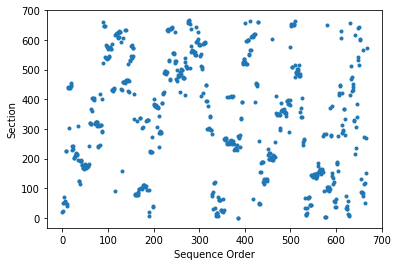

PHYS ﻿4.0 Introduction to Dynamics: Newton’s Laws of Motion
PHYS ﻿4.2 Newton’s First Law of Motion: Inertia
PHYS ﻿8.1 Linear Momentum and Force
PHYS ﻿8.2 Impulse
PHYS ﻿10.6 Collisions of Extended Bodies in Two Dimensions
PHYS ﻿8.5 Inelastic Collisions in One Dimension
PHYS ﻿8.4 Elastic Collisions in One Dimension
PHYS ﻿8.6 Collisions of Point Masses in Two Dimensions
PHYS ﻿28.5 Relativistic Momentum
PHYS ﻿28.6 Relativistic Energy


In [5]:
# Here is a quick example.
# Make a plot of an example path.
starting_pt = 20
good_path = find_good_path(M,starting_pt)
plt.plot(good_path,'.')
plt.xlabel('Sequence Order')
plt.ylabel('Section')
plt.show()

for i in good_path[:10]:
    print(OS_titles[i])

100%|██████████| 500/500 [34:00<00:00,  4.08s/it]


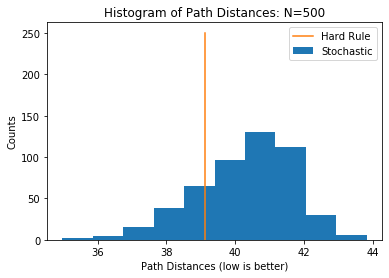

In [6]:
# Generate multiple paths using the probability parameter.
# Compare the total path distances.  
# The result shows that the rigid path (prob=1) is not necessarilly the best.
# (i.e., being locally greedy is not good.)

pdist = find_pdist(M) 

starting_pt = 20
topN = 50
numIter = 500
prob = 0.8

pathdists = np.zeros(numIter+1)
# Rigid path.
good_path = find_good_path(M,starting_pt,prob=1.0)
pathdists[0] = calculate_path_dist(pdist,good_path[:topN])

# Explore other path using prob<1.0.
for i in tqdm(range(numIter)):
    good_path = find_good_path(M,starting_pt,prob=prob)
    #print(good_path[:topN])
    pathdists[i+1] = calculate_path_dist(pdist,good_path[:topN])

plt.hist(pathdists[1:])
plt.plot(np.array([0,0])+pathdists[0],np.array([0,len(pathdists)*0.5]))
plt.xlabel('Path Distances (low is better)')
plt.ylabel('Counts')
plt.legend(('Hard Rule','Stochastic'))
plt.title('Histogram of Path Distances: N=%d'%(len(pathdists)-1))
plt.show()

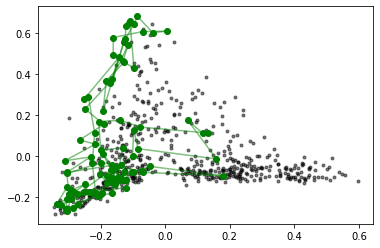

In [8]:
# Visualize the path on 2D PCA space.
import sklearn.decomposition # PCA, FastICA
  
def plot_route_2D (M, optimal_path, pathlen=10, texton=False, color='g'):
    # k = number of edges to display.
    N, d = M.shape
    if d>2: # high dimensional data, so do PCA.
        pca_operator = sklearn.decomposition.PCA(n_components=2)
        X = pca_operator.fit_transform(M)
    else:
        X = M
    
    for i in range(N): # Display all points as small dot.
        plt.plot(X[i,0],X[i,1],'.',color='k',alpha=0.5)
        
    for i in optimal_path[:pathlen+1]:
        plt.plot(X[i,0],X[i,1],'o',color=color)
        if texton:
            plt.text(X[i,0],X[i,1],str(i))

    for i in range(pathlen):
        p1 = optimal_path[i]
        p2 = optimal_path[i+1]
        plt.plot([X[p1, 0],X[p2, 0]],[X[p1,1],X[p2, 1]],color=color,alpha=0.5)

plot_route_2D (M, good_path, pathlen=100)
plt.show()


### Analysis of a path

Given a particular path through documents, it is possible to select the terms with large tf-idf values on average.  This analysis is akin to identifying the important features within a dataset.

In [9]:
def find_sig_features (M, path, pathlen=0):
    # Find features (column indices) with significance within path.
    # The significance could be high values or high variance, 
    assert len(path)>0 # path should not be empty.
    assert len(path)>=pathlen
    if pathlen==0:
        pathlen = len(path)

    M_sliced = M[path[:pathlen],:]

    topN = 5
    sig_features = list()

    # Which features have the largest mean value?
    M_summary = np.mean(M_sliced,axis=0)
    idx = np.argsort(M_summary)[::-1][:topN]
    for i in idx:
        sig_features.append(i)

    # Which features have the largest variance value?
    #M_summary = np.var(M_sliced,axis=0)
    #idx = np.argsort(M_summary)[::-1][:topN]
    #sig_features.append(idx)

    # We could have multiple strategies for finding the significant
    # features, and then find which index appears most often.
    # Not implemented.
    return sig_features

# Example.

pathlen = 10
M = M_OS
# N = number of sections, D = number of terms.
N,D = M.shape
pdist = find_pdist(M)

starting_pt = 20
good_path = find_good_path(M,starting_pt,prob=1.0)
sig_features = find_sig_features(M,good_path,pathlen=pathlen)

# Report what we have so far.
print('Good Paths')
for i in good_path[:pathlen]:
    print('\t',OS_titles[i])
print('Significant terms for this path:')
for i in sig_features:
    print('\t',T_OS[i])

Good Paths
	 PHYS ﻿4.0 Introduction to Dynamics: Newton’s Laws of Motion
	 PHYS ﻿4.2 Newton’s First Law of Motion: Inertia
	 PHYS ﻿8.1 Linear Momentum and Force
	 PHYS ﻿8.2 Impulse
	 PHYS ﻿10.6 Collisions of Extended Bodies in Two Dimensions
	 PHYS ﻿8.5 Inelastic Collisions in One Dimension
	 PHYS ﻿8.4 Elastic Collisions in One Dimension
	 PHYS ﻿8.6 Collisions of Point Masses in Two Dimensions
	 PHYS ﻿28.5 Relativistic Momentum
	 PHYS ﻿28.6 Relativistic Energy
Significant terms for this path:
	 veloc
	 mass
	 kinet
	 object
	 energi


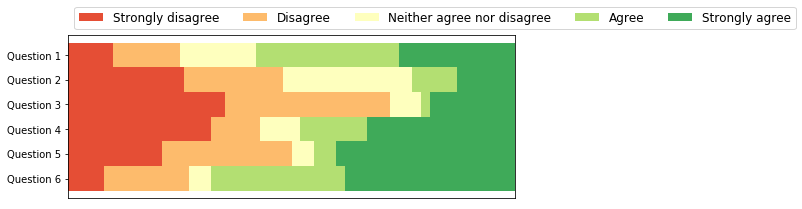

In [10]:
# Visualization of path.

def plot_horizontal_bar (results, category_names):
    # Taken from matplotlib example.
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(8,0.5*len(results)))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=1,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        #for y, (x, c) in enumerate(zip(xcenters, widths)):
        #    ax.text(x, y, str(int(c)), ha='center', va='center',
        #            color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax

# Test the plotting routine.
category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}
plot_horizontal_bar(results, category_names)
plt.show()


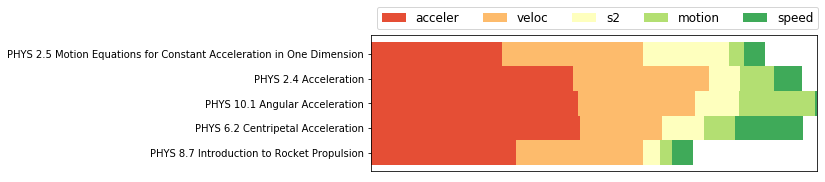

In [11]:
# Another visualization routine, but not used much.
def plot_path_sig_terms (M_OS,T_OS,OS_titles,starting_pt,pathlen=10):
    path = find_good_path(M_OS,starting_pt,prob=1.0)
    sig_features = find_sig_features(M_OS,path,pathlen=pathlen)
    sig_features = np.array(sig_features)

    sections = []
    for i in path[:pathlen]:
        sections.append(OS_titles[i])
    terms = []
    for i in sig_features:
        terms.append(T_OS[i])

    # Fill in the data structure, which would be useful for plotting.
    results = {}
    for sec in path[:pathlen]:
        results[OS_titles[sec]] = M_OS[sec,sig_features]
    plot_horizontal_bar(results, terms)
    plt.savefig('tmp.png',bbox_inches='tight',dpi=300)
    plt.show()


plot_path_sig_terms (M_OS,T_OS,OS_titles,10,pathlen=5)
#plot_path_sig_terms (M_OS,T_OS,OS_titles,10,pathlen=10)

### Analysis with Starting-Ending Points

In [53]:
# The following function is a better version when both starting and ending
# points have been specified.  The earlier function, find_good_path, can
# be used when there is only starting point.

def find_path_start_end (M, starting_point, ending_point, prob=1.0, pathlen=0):
    # input: M is number of points (row) x dimensions (column)
    # output: good_path = list of length N
    # prob = Probability for accepting and rejecting the next point.
    #        (trying to avoid local min, c.f., simulated annealing).
    # prob = 1.0 (always accept the next closest point)

    # pdist = N x N 
    pdist = find_pdist(M)

    good_path = list()
    good_path.append(starting_point)

    N, _ = pdist.shape

    # Figure out how long path should be, based on the pathlen parameter.
    if pathlen>0: # pathlen was specified, so use that.
        if pathlen>N: # but there is a limit of N.
            pathlen = N
    else: # pathlen was not specified, so get the full path.
        pathlen = N

    for i in range(pathlen-1):
        curr_pt = good_path[i]

        dist_from_curr_pt = pdist[curr_pt,:]
        # index of points in ascending order of distances.
        idx = np.argsort(dist_from_curr_pt).tolist() # ordered index values.
        for j in good_path:
            idx.remove(j) # remove index that was already visited.

        # now index should only contain points that were unvisited, in 
        # an ascending order of distances from the current point.

        # Now, roll dice, and probabilistically accept points.
        p = np.random.rand(len(idx)) < prob
        if any(p):
            #print(np.argwhere(p==True)[0])
            # Find the first index of True value.
            j = idx[np.argwhere(p==True)[0][0]]
        else: # if no points were selected, choose a random point.
            j = idx[np.random.randint(len(idx))]

        good_path.append(j)
        if j==ending_point: 
            # if ending_point was specified by the user, and if it was reached,
            # end the loop early.
            break
    #if pathlen==N:
    #    assert all(np.sort(good_path)==range(pathlen))
    if ending_point>0: 
        # if ending_point was specified, but never reached, return empty.
        if ending_point not in good_path:
            good_path = list()
    return good_path


Pick pt1 and pt2 (starting and ending points) that might make interesting connections.
Find the index number by examining the table of contents.
Specify pt0 and pt1 in the cell below, and run the code.

In [77]:
OS_titles[483]

'BIOL \ufeff14.6 DNA Repair'

pt0 (start):  PHYS ﻿19.1 Electric Potential Energy: Potential Difference
pt1 (endng):  BIOL ﻿35.2 How Neurons Communicate
Note: the terms are selected based on the tf-idf values thru
      the entire path, so some may appear in one plot, but not
      in others.
Interesting Path 1


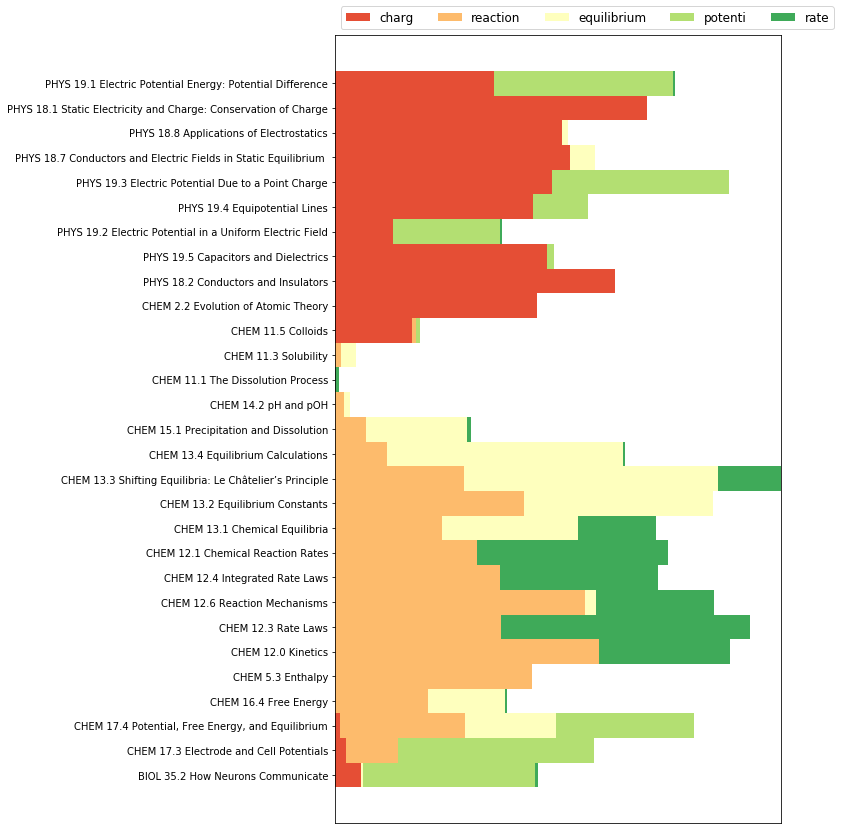

Interesting Path 2


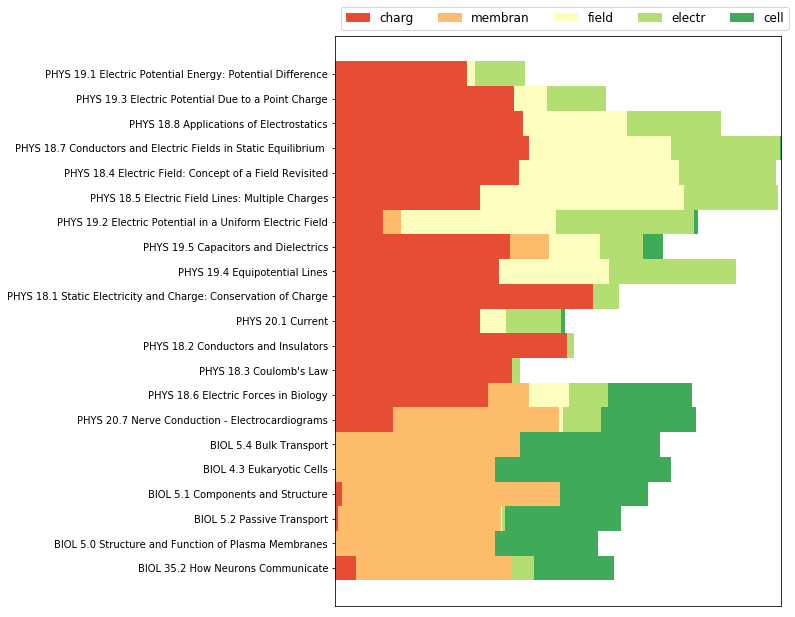

Interesting Path 3


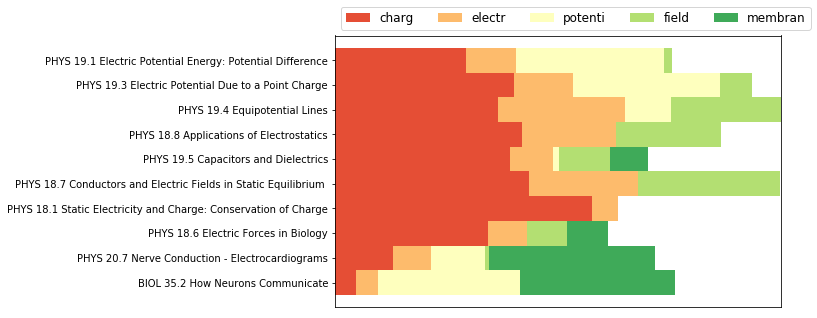

Interesting Path 4


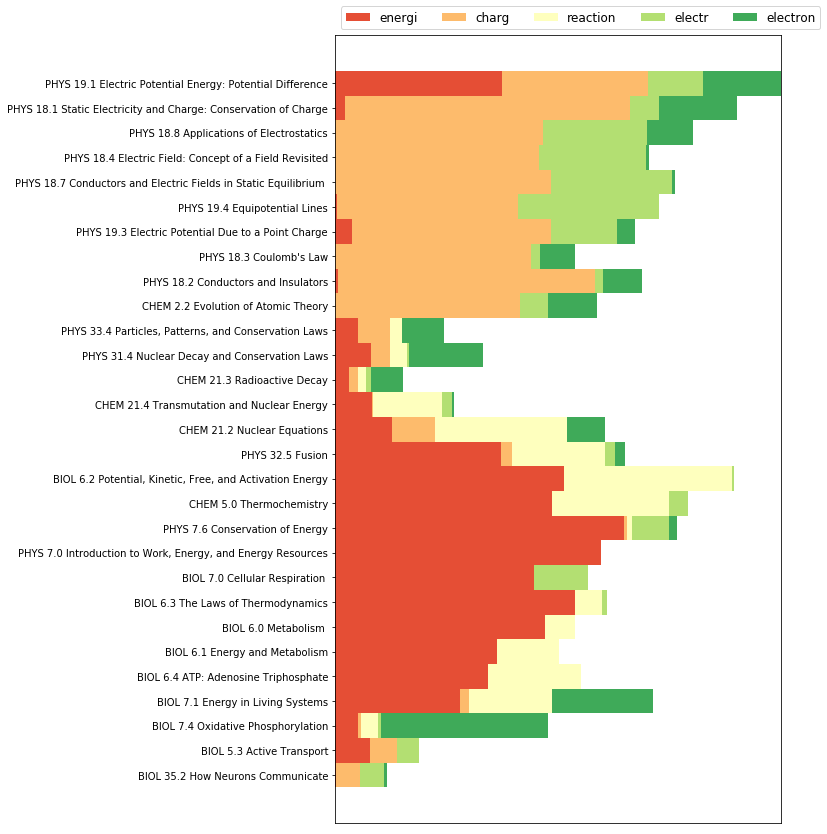

Interesting Path 5


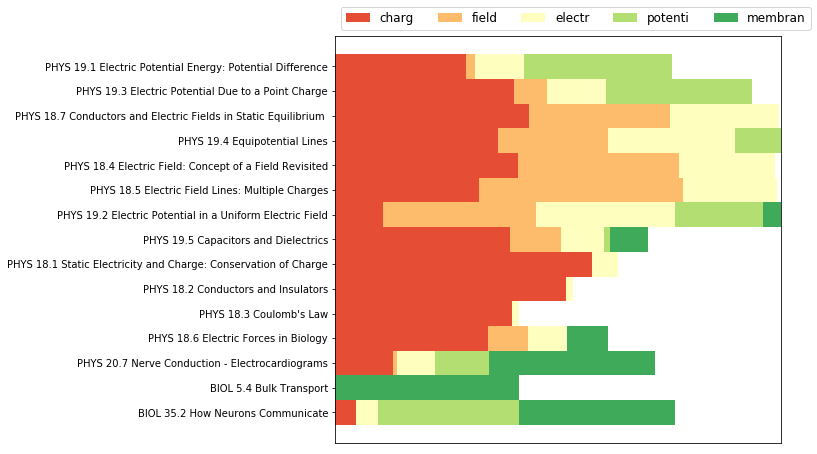

[[144, 135, 142, 141, 146, 147, 145, 148, 136, 287, 345, 343, 341, 361, 368, 358, 357, 356, 355, 347, 350, 352, 349, 346, 307, 375, 380, 379, 595], [144, 146, 142, 141, 138, 139, 145, 148, 147, 135, 152, 136, 137, 140, 158, 437, 429, 434, 435, 433, 595], [144, 146, 147, 142, 148, 141, 135, 140, 158, 595], [144, 135, 142, 138, 141, 147, 146, 137, 136, 287, 267, 251, 409, 410, 408, 260, 440, 304, 46, 40, 444, 441, 438, 439, 442, 445, 448, 436, 595], [144, 146, 141, 147, 138, 139, 145, 148, 135, 136, 137, 140, 158, 437, 595]]


In [80]:
# Generate a few examples of the same starting and ending points.
# Not interesting (too similar)
pt0 = 248 # PHYS nuclear radiation
pt1 = 497 # BIOL cancer

pt0 = 483 # BIOL 14.6 DNA repair
pt1 = 25 # PHYS 4.5 Example of forces

pt0 = 144 # PHYS potential
pt1 = 595 # BIOL neural communication

print("pt0 (start): ", OS_titles[pt0])
print("pt1 (endng): ", OS_titles[pt1])
print('Note: the terms are selected based on the tf-idf values thru')
print('      the entire path, so some may appear in one plot, but not')
print('      in others.')

prob = 0.5
pathlen = 30
counter = 0
counter_max = 5
interesting_path = list()
for i in range(10000):
    if (counter>=counter_max):
        break
    path = find_path_start_end (M_OS,pt0,pt1,prob=prob)
    if len(path)>0 and len(path)<=pathlen:
        interesting_path.append(path)
        counter = counter + 1
        print("Interesting Path %d"%counter)
        sig_features = find_sig_features(M_OS,path)
        sig_features = np.array(sig_features)
        sections = []
        for i in path:
            sections.append(OS_titles[i])
        terms = []
        for i in sig_features:
            terms.append(T_OS[i])

        # Fill in the data structure, which would be useful for plotting.
        results = {}
        for sec in path:
            results[OS_titles[sec]] = M_OS[sec,sig_features]
        plot_horizontal_bar(results, terms)
        plt.savefig('interesting_path_%d_%d_save%d.png'%(pt0,pt1,counter),bbox_inches='tight',dpi=300)
        plt.show()
        
filename = 'interesting_path_%d_%d.p'%(pt0,pt1)
with open(filename, 'wb') as f:
    pickle.dump(interesting_path, f)
print(interesting_path)

[144, 146, 141, 138, 139, 147, 142, 135, 287, 136, 137, 140, 158, 595]
[144, 46, 40, 441, 304, 440, 438, 439, 442, 436, 595]


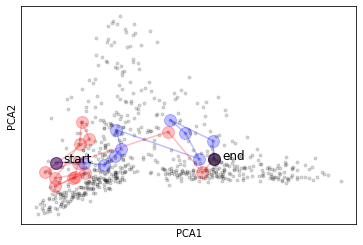

In [51]:
# Display the paths on a scatter plot.
# The code is based on plot_route_2d function.

N, d = M.shape
if d>2: # high dimensional data, so do PCA.
    pca_operator = sklearn.decomposition.PCA(n_components=2)
    X = pca_operator.fit_transform(M)
else:
    X = M
for i in range(N): # Display all points as small dot.
    plt.plot(X[i,0],X[i,1],'.',color='k',alpha=0.15)
# for i in range(pathlen):
#     p1 = optimal_path[i]
#     p2 = optimal_path[i+1]
#     plt.plot([X[p1, 0],X[p2, 0]],[X[p1,1],X[p2, 1]],color=color,alpha=0.5,markersize=24)
# plt.plot()

        
# Examine the saved examples and pick nice examples of curriculum.
path_ex = [1,2]
colors = ('r','b')
assert len(path_ex)==len(colors)
for i in range(len(path_ex)):
    c = colors[i]
    this_path = interesting_path[path_ex[i]]
    print(this_path)
    for pt in this_path:
        plt.plot(X[pt,0],X[pt,1],'.',color=c,alpha=0.25,markersize=24)
    for p1, p2 in zip(this_path[:-1], this_path[1:]):
        plt.plot([X[p1,0],X[p2,0]],[X[p1,1],X[p2, 1]],color=c,alpha=0.25)
# Starting and end points
plt.plot(X[this_path[0],0],X[this_path[0],1],'o',color='k',alpha=0.25,markersize=12)
plt.plot(X[this_path[-1],0],X[this_path[-1],1],'o',color='k',alpha=0.50,markersize=12)
plt.text(X[this_path[0],0] +0.025,X[this_path[0],1],'start',fontsize=12)
plt.text(X[this_path[-1],0]+0.025,X[this_path[-1],1],'end',fontsize=12)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xticks(())
plt.yticks(())

plt.savefig('example_paths.png',dpi=600)
plt.show()

# Experimental Codes

## A few exmaples of dimensionality reduction codes.

Embedded PCA in 0.07 seconds.
Embedded ICA in 0.41 seconds.
Embedded MDS in 13.44 seconds.
Embedded t-SNE in 5.47 seconds.


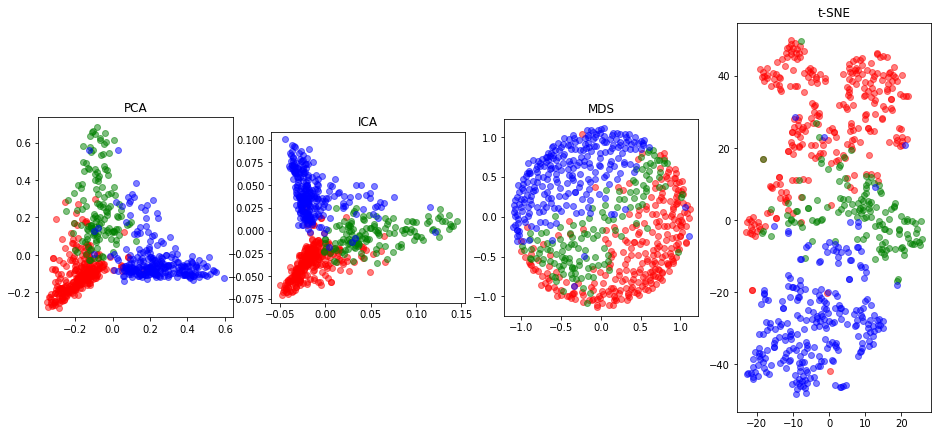

In [ ]:
# Use various methods to put the data in 2 dimensional space.
import sklearn.decomposition # PCA, FastICA
import sklearn.manifold # MDS, t-SNE

if 1:
    n_components = 2

    start = time.time()
    pca_operator = sklearn.decomposition.PCA(n_components=n_components)
    tree_pca = pca_operator.fit_transform(M)
    end = time.time()
    print("Embedded PCA in {:.2f} seconds.".format(end-start))

    start = time.time()
    ica_operator = sklearn.decomposition.FastICA(n_components=n_components)
    tree_ica = ica_operator.fit_transform(M)
    end = time.time()
    print("Embedded ICA in {:.2f} seconds.".format(end-start))

    start = time.time()
    mds_operator = sklearn.manifold.MDS(n_components=n_components, metric=True, n_jobs=-2)
    tree_mds = mds_operator.fit_transform(M)
    end = time.time()
    print("Embedded MDS in {:.2f} seconds.".format(end-start))

    start = time.time()
    tsne_operator = sklearn.manifold.TSNE(n_components=n_components)
    tree_tsne = tsne_operator.fit_transform(M)
    end = time.time()
    print("Embedded t-SNE in {:.2f} seconds.".format(end-start))

    # plot everything
    #import matplotlib.pyplot as plt
    f, axes = plt.subplots(1,4, figsize=(16,10))
    ax1, ax2, ax3, ax4 = axes.ravel()

    def myplot (xy,categories,ax,title_str=''):
        colors = list(('red','green','blue'))
        for k,i in enumerate(np.unique(categories)):
            ax.plot(xy[(categories==i),0],xy[(categories==i),1],'o',
                    color=colors[k],alpha=0.5)
        ax.set_title(title_str)
        ax.set_aspect('equal')
        return

    cat = corpus_category
    myplot(tree_pca,cat,ax1,title_str='PCA')
    myplot(tree_ica,cat,ax2,title_str='ICA')
    myplot(tree_mds,cat,ax3,title_str='MDS')
    myplot(tree_tsne,cat,ax4,title_str='t-SNE')


## Network-style analysis
Using networkx module

In [ ]:
# Toy example for networksx
import networkx
import matplotlib.pyplot as plt

edges = [(1, 2, 1), (2, 3, 2), (3, 4, 1), (4, 5, 2)]
G = networkx.Graph()
for start, end, length in edges:
    # You can attach any attributes you want when adding the edge
    G.add_edge(start, end, length=length)
networkx.shortest_path_length(G, 1, 5, weight='length')

#networkx.draw_networkx(G)
#networkx.drawing.nx_pylab.draw_spring(G)
#networkx.drawing.nx_pylab.draw_kamada_kawai(G)
networkx.drawing.nx_pylab.draw_random(G)

6

In [ ]:
import networkx

N, dim = M.shape
G = networkx.Graph()
for i, title in enumerate(OS_titles):
    G.add_node(i)

# pairwise distance.
pdist = np.sqrt(np.sum((M[None, :] - M[:, None])**2, -1))
pdist = pdist**4 # introduce some nonlinearity, in order to emphasize closer neighbors.
# edge_threshold will be used to decide whether to add an edge between two nodes.
# If pdist is > edge_threshold, do not add edge.
edge_threshold = np.mean(pdist) * 1.5
print(edge_threshold)

for i in range(N):
    for j in range(i+1,N):
        length = pdist[i,j]
        # Only add edges if they are close enough.
        if length < edge_threshold:
            G.add_edge(i,j,length=length)

#networkx.draw_networkx(G)
#networkx.drawing.nx_pylab.draw_spring(G)
networkx.draw_networkx(G,with_labels=True)

4.862941779537746


In [ ]:
# Find the shortest path between a source node and a target node.
source = 30
target = 250
path = networkx.shortest_path(G,source=source,target=target,weight='length')
for i in path:
    print(OS_titles[i])
# path_gen = networkx.shortest_simple_paths(G,source=0,target=100,weight='length')
# for path in path_gen:
#     print(path)

﻿5.1 Friction
﻿7.5 Nonconservative Forces
﻿7.6 Conservation of Energy
﻿28.6 Relativistic Energy
21.1 Nuclear Structure and Stability
﻿31.3 Substructure of the Nucleus
